In [1]:
import geopandas as gpd
import os
import pandas as pd
import rasterio
import shapely

# Keep CRS consistent, always use espg:4326
CRS = {'init':'epsg:4326'}

In [2]:
# Geojson file with building polygons. Obtained from OSM via Geofabrik (http://download.geofabrik.de/)
buildings = gpd.read_file('/Users/apando/school/cs230/project/datasets/hurricane_maria/ground_truth/buildings/buildings.geojson')

In [3]:
print(len(buildings))
buildings.head()

1498316


,geometry
0,"POLYGON ((-66.04452809999999 18.4021147, -66.0..."
1,"POLYGON ((-66.0463973 18.4021623, -66.0463973 ..."
2,"POLYGON ((-66.0483139 18.4023847, -66.0483112 ..."
3,"POLYGON ((-66.0485137 18.4023866, -66.04864739..."
4,"POLYGON ((-66.0470406 18.4073665, -66.0470528 ..."


In [125]:
# Directory containing *.gdb files from FEMA with damage points from visual assessment 
# (https://data.femadata.com/NationalDisasters/HurricaneMaria/Data/DamageAssessments/)
damage_dir = '/Users/apando/school/cs230/project/datasets/hurricane_maria/ground_truth/damage'
damage_list = []
for gdb_dir in os.listdir(damage_dir):
    if gdb_dir.endswith('.gdb'):
        dmg = gpd.read_file(damage_dir + "/" + gdb_dir)
        print("Appending {} damage points".format(len(dmg)))
        damage_list.append(dmg)
        
damage_pts = gpd.GeoDataFrame(pd.concat(damage_list, ignore_index=True), crs=CRS)

print("Added {0} damage points from {1} datasets".format(len(damage_pts), len(damage_list)))

Appending 72640 damage points
Appending 12837 damage points
Appending 9264 damage points
Appending 28028 damage points
Appending 18728 damage points
Appending 35357 damage points
Appending 30788 damage points
Appending 17529 damage points
Appending 53664 damage points
Appending 14314 damage points
Appending 50116 damage points
Appending 46190 damage points
Appending 9672 damage points
Added 399127 damage points from 13 datasets


In [126]:
damage_pts = damage_pts.drop_duplicates(['LONGITUDE', 'LATITUDE'])
print(len(damage_pts))

126221


In [134]:
print(damage_pts['DMG_LEVEL'].unique())
print(damage_pts['DMG_TYPE'].unique())

['MAJ' 'MIN' 'DES' 'AFF']
['FL' 'WI' ' ']


In [127]:
# Map damage points to buildings. For our experiment, we will not include 
# damage points that don't have a building associated with them, as we are
# specifically looking for damaged buildings.

# Right join to keep the building polygons
buildings_dmg_points = gpd.sjoin(damage_pts, buildings, how="right", op="within")

buildings_dmg_points.head()

,index_left,DMG_LEVEL,DMG_TYPE,ASMT_TYPE,IN_DEPTH,WIND_SPEED,PGA,ACCESS,COUNTY,STATE,...,IMG_DATE,EVENT_NAME,EVENT_DATE,SOURCE,DIS_NUMBER,COMMENTS,LONGITUDE,LATITUDE,USNG,geometry
index_right,,,,,,,,,,,,,,,,,,,,,
18,11457.0,MIN,FL,MOD,None,UNK,None,UNK,,,...,None,Hurricane Maria,None,FEMA,None,None,-66.672340,18.481077,None,"POLYGON ((-66.6722827 18.4811393, -66.6722821 ..."
66,84884.0,AFF,WI,RS,None,UNK,None,UNK,,,...,None,Hurricane Maria,None,FEMA,None,None,-66.019852,18.248766,None,"POLYGON ((-66.0213978 18.2498477, -66.0201426 ..."
68,80290.0,AFF,WI,RS,None,UNK,None,UNK,,,...,None,Hurricane Maria,None,FEMA,None,None,-66.125748,18.440516,None,"POLYGON ((-66.1261362 18.4406596, -66.1257715 ..."
74,172600.0,AFF,WI,RS,None,UNK,None,UNK,,,...,None,Hurricane Maria,None,FEMA,None,None,-65.974953,18.391367,None,"POLYGON ((-65.9747436 18.3912258, -65.9745781 ..."
76,80934.0,AFF,WI,RS,None,UNK,None,UNK,,,...,None,Hurricane Maria,None,FEMA,None,None,-66.106323,18.466669,None,"POLYGON ((-66.10649340000001 18.4665909, -66.1..."


In [128]:
print(len(buildings_dmg_points))

1502705


In [129]:
# Split damaged and non-damaged buildings
damaged_buildings = buildings_dmg_points[pd.notnull(buildings_dmg_points['index_left'])]
non_damaged_buildings = buildings_dmg_points[~pd.notnull(buildings_dmg_points['index_left'])]

print("Found {0} damaged buildings and {1} non-damaged buildings".format(len(damaged_buildings), len(non_damaged_buildings)))

Found 92361 damaged buildings and 1410344 non-damaged buildings


In [135]:
damaged_buildings['is_damaged'] = True
non_damaged_buildings['is_damaged'] = False
all_buildings = pd.concat([damaged_buildings, non_damaged_buildings], ignore_index=True)

print("{} total buildings".format(len(all_buildings)))

/Users/apando/miniconda3/envs/disaster-detection/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


1502705 total buildings


/Users/apando/miniconda3/envs/disaster-detection/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [136]:
# Find the NOAA tiles each these buildings is in.

# First, map tiles to their bounding box polygons.
# Root dir is the high-level directory where tiles are located.
tile_coords_map = pd.DataFrame(columns=['tile_filename', 'tile_bbox'])
tile_coords_list = []
num_tiles = 0
for curr_dir, _, file_list in os.walk('/Users/apando/school/cs230/project/datasets/hurricane_maria/post_event/noaa/tiles'):
    for fname in file_list:
        # Do not include pyramids, which are stored in a /1 dir with in the tiles/ directory.
        if not curr_dir.endswith('1') and fname.endswith(".tif"):
            num_tiles += 1
            tile_loc = curr_dir + "/" + fname
            
            # Find the bounding box of the tile to form a mapping DataFrame
            tile = rasterio.open(tile_loc)
            tile_coords_list.append((tile_loc, 
                                     (tile.bounds.left, tile.bounds.bottom, tile.bounds.right, tile.bounds.top)))
            
            if num_tiles % 1000 == 0:
                print("Processed {0} tiles... curr tile: {1}".format(num_tiles, fname))

tile_coords_map_cols = list(map(list, zip(*tile_coords_list)))
tile_coords_map = gpd.GeoDataFrame({'tile_filename': tile_coords_map_cols[0], 
                                    'tile_bbox': list(map(lambda x: shapely.geometry.box(*x), 
                                                          tile_coords_map_cols[1]))},
                                  geometry='tile_bbox', crs=CRS)

print("Mapped {} tiles to bboxes".format(len(tile_coords_map)))

Processed 1000 tiles... curr tile: 20170924bC0660300w182700n_16_08.tif
Processed 2000 tiles... curr tile: 20170924bC0663430w182830n_03_02.tif
Processed 3000 tiles... curr tile: 20170926aC0661200w175830n_16_13.tif
Processed 4000 tiles... curr tile: 20170924bC0663000w182700n_14_03.tif
Processed 5000 tiles... curr tile: 20170924bC0663130w182700n_03_08.tif
Processed 6000 tiles... curr tile: 20170924bC0660300w182700n_13_07.tif
Processed 7000 tiles... curr tile: 20170926aC0663600w180000n_07_15.tif
Processed 8000 tiles... curr tile: 20170924aC0654930w180430n_02_08.tif
Processed 9000 tiles... curr tile: 20170924aC0653130w180600n_13_10.tif
Processed 10000 tiles... curr tile: 20170926aC0663900w180000n_11_05.tif
Processed 11000 tiles... curr tile: 20170926bC0652700w180730n_15_02.tif
Processed 12000 tiles... curr tile: 20170924bC0662230w182830n_19_11.tif
Processed 13000 tiles... curr tile: 20170924bC0655830w182700n_14_16.tif
Processed 14000 tiles... curr tile: 20170926aC0661630w175830n_11_09.tif
P

In [137]:
# Map buildings to the tiles they're in to crop them out

# Drop index from the previous join (we don't need it anymore)
all_buildings = all_buildings.drop(['index_left'], axis=1)
buildings_tile_map = gpd.sjoin(all_buildings, tile_coords_map, how="left", op="within")

# Remove buildings for which we don't have any satellite images
buildings_tile_map = buildings_tile_map[pd.notnull(buildings_tile_map['tile_filename'])]
print(len(buildings_tile_map))
print(buildings_tile_map.head())

240256
   DMG_LEVEL DMG_TYPE ASMT_TYPE IN_DEPTH WIND_SPEED   PGA ACCESS COUNTY STATE  \
2        AFF       WI        RS     None        UNK  None    UNK                
38       AFF       FL       MOD     None        UNK  None    UNK                
56       AFF       WI        RS     None        UNK  None    UNK                
57       AFF       WI        RS     None        UNK  None    UNK                
59       AFF       WI        RS     None        UNK  None    UNK                

    FIPS  ... SOURCE DIS_NUMBER COMMENTS  LONGITUDE   LATITUDE  USNG  \
2   None  ...   FEMA       None     None -66.125748  18.440516  None   
38   NaN  ...   FEMA       None     None -66.075722  18.456402  None   
56  None  ...   FEMA       None     None -65.810402  18.143759  None   
57  None  ...   FEMA       None     None -65.829788  18.139668  None   
59  None  ...   FEMA       None     None -65.825577  18.136524  None   

                                             geometry  is_damaged  \
2   

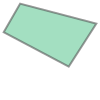

In [121]:
buildings_tile_map.iloc[44]['geometry']

In [145]:
# Note that it's possible for there to be more rows here than # of buildings,
# because we likely have more than 1 tile for the same buildings.
# To avoid biasing by having the same building in train/test/dev sets,
# the filename with building centroid coords will indicate whether it's the 
# same building or not and we can filter accordingly.
print("Total buildings: {}".format(len(buildings_tile_map)))
print("Damaged buildings: {}".format(len(buildings_tile_map[buildings_tile_map['is_damaged'] == True])))
print("Affected buildings: {}".format(len(buildings_tile_map[buildings_tile_map['DMG_LEVEL'] == 'AFF'])))
print("Destroyed buildings: {}".format(len(buildings_tile_map[buildings_tile_map['DMG_LEVEL'] == 'DES'])))
print("Major damage buildings: {}".format(len(buildings_tile_map[buildings_tile_map['DMG_LEVEL'] == 'MAJ'])))
print("Non-Damaged buildings: {}".format(len(buildings_tile_map[buildings_tile_map['is_damaged'] == False])))

Total buildings: 240256
Damaged buildings: 38394
Affected buildings: 20527
Destroyed buildings: 3658
Major damage buildings: 5615
Non-Damaged buildings: 201862


In [139]:
len(buildings_tile_map[buildings_tile_map['DMG_LEVEL'] == 'AFF'].drop_duplicates(['LATITUDE', 'LONGITUDE']))

19977

280777


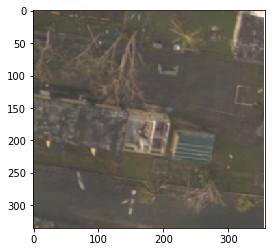

/Users/apando/school/cs230/project/datasets/hurricane_maria/post_event/noaa/tiles/20170924bC0662400w182830n_02_04.tif


In [109]:
# Explore different zoom levels
# First zoom level (pre-tuning): 0.00016
# 2nd zoom level: 0.00003
# 3rd zoom level: 0.00024

import random
from rasterio.mask import mask
from rasterio import plot
from shapely.geometry import Point

i = int(random.random()*len(buildings_tile_map))
print(i)
#i = 17492
row = buildings_tile_map.iloc[i]

with rasterio.open(row['tile_filename']) as src:
    building = row['geometry']
    building_center = Point(building.centroid.x, building.centroid.y)
    p = building_center.buffer(0.00024, cap_style=3).envelope
    out_img, out_transform = mask(src, [p], crop=True)
    plot.show(out_img)
    
    out_meta = src.meta.copy()
    
    # Save the resulting raster, as a 128x128 image
    out_meta.update({
        "driver": "JPEG",
        "height": 128,
        "width": 128,
        "transform": out_transform
    })
    
    with rasterio.open('/Users/apando/Downloads/test.jpeg', 'w', **out_meta) as dest:
        dest.write(out_img)
    
print(row['tile_filename'])

In [142]:
# Crop out building from the tile, and save it in a separate file
# as a 128x128 px image.

# Hyperparameters here are:
#     - image size
#     - buffer around the building

import numpy as np
from rasterio.mask import mask

BASE_DIR = '/Users/apando/school/cs230/project/datasets/hurricane_maria/building_crops_noaa_rezoom/'

bldg_counter = 0
des_bldg_counter = 0
aff_bldg_counter = 0
maj_bldg_counter = 0
min_bldg_counter = 0
unk_bldg_counter = 0
no_dmg_bldg_counter = 0

for _, row in buildings_tile_map.iterrows():
    bldg_counter += 1
    
    if bldg_counter % 200 == 0:
        print("Processed {0} buildings... {1} DES, {2} AFF, {3} ND".format(bldg_counter, des_bldg_counter, aff_bldg_counter, no_dmg_bldg_counter))
    
    building = row['geometry']
    x, y = building.centroid.x, building.centroid.y
    building_center = Point(x, y)
    with rasterio.open(row['tile_filename']) as src:
        # Add a small square buffer to the building polygon's centroid before cropping.
        p = building_center.buffer(0.00024, cap_style=3).envelope
        out_img, out_transform = mask(src, [p], crop=True)
    out_meta = src.meta.copy()
    
    # Save the resulting raster, as a 128x128 image
    out_meta.update({
        "driver": "JPEG",
        "height": 128,
        "width": 128,
        "transform": out_transform
    })
    
    # Set up data in Keras ImageDataGenerator-friendly format
    dmg_label = 'nd'
    if row['is_damaged']:
        if row['DMG_LEVEL'] == 'DES':
            des_bldg_counter += 1
            dmg_label = 'des'
        elif row['DMG_LEVEL'] == 'AFF':
            aff_bldg_counter += 1
            dmg_label = 'aff'
        elif row['DMG_LEVEL'] == 'MAJ':
            maj_bldg_counter += 1
            dmg_label = 'maj'
        elif row['DMG_LEVEL'] == 'MIN':
            min_bldg_counter += 1
            dmg_label = 'min'
        else:
            unk_bldg_counter += 1
            dmg_label = 'unk'
        out_dir = BASE_DIR + 'damaged/'
    else:
        no_dmg_bldg_counter += 1
        out_dir = BASE_DIR + 'non_damaged/'        
    
    # Preserve tile name in case there's multiple images for 1 building (don't overwrite)
    tile_name = row['tile_filename'].split('/')[-1].split('.')[0]
        
    with rasterio.open(out_dir + '{0},{1}_{2}_{3}.jpeg'.format(x, y, tile_name, dmg_label), 'w', **out_meta) as dest:
        dest.write(out_img)
    
print("Processed {} buildings".format(bldg_counter))

Processed 200 buildings... 18 DES, 135 AFF, 0 ND
Processed 400 buildings... 19 DES, 302 AFF, 0 ND
Processed 600 buildings... 20 DES, 398 AFF, 0 ND
Processed 800 buildings... 26 DES, 533 AFF, 0 ND
Processed 1000 buildings... 34 DES, 676 AFF, 0 ND
Processed 1200 buildings... 34 DES, 760 AFF, 0 ND
Processed 1400 buildings... 34 DES, 849 AFF, 0 ND
Processed 1600 buildings... 34 DES, 923 AFF, 0 ND
Processed 1800 buildings... 34 DES, 992 AFF, 0 ND
Processed 2000 buildings... 34 DES, 1076 AFF, 0 ND
Processed 2200 buildings... 34 DES, 1154 AFF, 0 ND
Processed 2400 buildings... 34 DES, 1213 AFF, 0 ND
Processed 2600 buildings... 34 DES, 1276 AFF, 0 ND
Processed 2800 buildings... 34 DES, 1365 AFF, 0 ND
Processed 3000 buildings... 37 DES, 1415 AFF, 0 ND
Processed 3200 buildings... 41 DES, 1427 AFF, 0 ND
Processed 3400 buildings... 47 DES, 1434 AFF, 0 ND
Processed 3600 buildings... 48 DES, 1444 AFF, 0 ND
Processed 3800 buildings... 51 DES, 1454 AFF, 0 ND
Processed 4000 buildings... 51 DES, 1549 AFF

Processed 31200 buildings... 2888 DES, 15455 AFF, 0 ND
Processed 31400 buildings... 2892 DES, 15541 AFF, 0 ND
Processed 31600 buildings... 2913 DES, 15665 AFF, 0 ND
Processed 31800 buildings... 2928 DES, 15787 AFF, 0 ND
Processed 32000 buildings... 2962 DES, 15908 AFF, 0 ND
Processed 32200 buildings... 2964 DES, 16086 AFF, 0 ND
Processed 32400 buildings... 2965 DES, 16271 AFF, 0 ND
Processed 32600 buildings... 2976 DES, 16431 AFF, 0 ND
Processed 32800 buildings... 2978 DES, 16602 AFF, 0 ND
Processed 33000 buildings... 2978 DES, 16802 AFF, 0 ND
Processed 33200 buildings... 2986 DES, 16978 AFF, 0 ND
Processed 33400 buildings... 2988 DES, 17150 AFF, 0 ND
Processed 33600 buildings... 3008 DES, 17285 AFF, 0 ND
Processed 33800 buildings... 3008 DES, 17451 AFF, 0 ND
Processed 34000 buildings... 3042 DES, 17584 AFF, 0 ND
Processed 34200 buildings... 3067 DES, 17745 AFF, 0 ND
Processed 34400 buildings... 3078 DES, 17923 AFF, 0 ND
Processed 34600 buildings... 3154 DES, 18023 AFF, 0 ND
Processed 

Processed 59800 buildings... 3658 DES, 20527 AFF, 21405 ND
Processed 60000 buildings... 3658 DES, 20527 AFF, 21605 ND
Processed 60200 buildings... 3658 DES, 20527 AFF, 21805 ND
Processed 60400 buildings... 3658 DES, 20527 AFF, 22005 ND
Processed 60600 buildings... 3658 DES, 20527 AFF, 22205 ND
Processed 60800 buildings... 3658 DES, 20527 AFF, 22405 ND
Processed 61000 buildings... 3658 DES, 20527 AFF, 22605 ND
Processed 61200 buildings... 3658 DES, 20527 AFF, 22805 ND
Processed 61400 buildings... 3658 DES, 20527 AFF, 23005 ND
Processed 61600 buildings... 3658 DES, 20527 AFF, 23205 ND
Processed 61800 buildings... 3658 DES, 20527 AFF, 23405 ND
Processed 62000 buildings... 3658 DES, 20527 AFF, 23605 ND
Processed 62200 buildings... 3658 DES, 20527 AFF, 23805 ND
Processed 62400 buildings... 3658 DES, 20527 AFF, 24005 ND
Processed 62600 buildings... 3658 DES, 20527 AFF, 24205 ND
Processed 62800 buildings... 3658 DES, 20527 AFF, 24405 ND
Processed 63000 buildings... 3658 DES, 20527 AFF, 24605 

Processed 87600 buildings... 3658 DES, 20527 AFF, 49205 ND
Processed 87800 buildings... 3658 DES, 20527 AFF, 49405 ND
Processed 88000 buildings... 3658 DES, 20527 AFF, 49605 ND
Processed 88200 buildings... 3658 DES, 20527 AFF, 49805 ND
Processed 88400 buildings... 3658 DES, 20527 AFF, 50005 ND
Processed 88600 buildings... 3658 DES, 20527 AFF, 50205 ND
Processed 88800 buildings... 3658 DES, 20527 AFF, 50405 ND
Processed 89000 buildings... 3658 DES, 20527 AFF, 50605 ND
Processed 89200 buildings... 3658 DES, 20527 AFF, 50805 ND
Processed 89400 buildings... 3658 DES, 20527 AFF, 51005 ND
Processed 89600 buildings... 3658 DES, 20527 AFF, 51205 ND
Processed 89800 buildings... 3658 DES, 20527 AFF, 51405 ND
Processed 90000 buildings... 3658 DES, 20527 AFF, 51605 ND
Processed 90200 buildings... 3658 DES, 20527 AFF, 51805 ND
Processed 90400 buildings... 3658 DES, 20527 AFF, 52005 ND
Processed 90600 buildings... 3658 DES, 20527 AFF, 52205 ND
Processed 90800 buildings... 3658 DES, 20527 AFF, 52405 

Processed 115200 buildings... 3658 DES, 20527 AFF, 76805 ND
Processed 115400 buildings... 3658 DES, 20527 AFF, 77005 ND
Processed 115600 buildings... 3658 DES, 20527 AFF, 77205 ND
Processed 115800 buildings... 3658 DES, 20527 AFF, 77405 ND
Processed 116000 buildings... 3658 DES, 20527 AFF, 77605 ND
Processed 116200 buildings... 3658 DES, 20527 AFF, 77805 ND
Processed 116400 buildings... 3658 DES, 20527 AFF, 78005 ND
Processed 116600 buildings... 3658 DES, 20527 AFF, 78205 ND
Processed 116800 buildings... 3658 DES, 20527 AFF, 78405 ND
Processed 117000 buildings... 3658 DES, 20527 AFF, 78605 ND
Processed 117200 buildings... 3658 DES, 20527 AFF, 78805 ND
Processed 117400 buildings... 3658 DES, 20527 AFF, 79005 ND
Processed 117600 buildings... 3658 DES, 20527 AFF, 79205 ND
Processed 117800 buildings... 3658 DES, 20527 AFF, 79405 ND
Processed 118000 buildings... 3658 DES, 20527 AFF, 79605 ND
Processed 118200 buildings... 3658 DES, 20527 AFF, 79805 ND
Processed 118400 buildings... 3658 DES, 

Processed 142600 buildings... 3658 DES, 20527 AFF, 104205 ND
Processed 142800 buildings... 3658 DES, 20527 AFF, 104405 ND
Processed 143000 buildings... 3658 DES, 20527 AFF, 104605 ND
Processed 143200 buildings... 3658 DES, 20527 AFF, 104805 ND
Processed 143400 buildings... 3658 DES, 20527 AFF, 105005 ND
Processed 143600 buildings... 3658 DES, 20527 AFF, 105205 ND
Processed 143800 buildings... 3658 DES, 20527 AFF, 105405 ND
Processed 144000 buildings... 3658 DES, 20527 AFF, 105605 ND
Processed 144200 buildings... 3658 DES, 20527 AFF, 105805 ND
Processed 144400 buildings... 3658 DES, 20527 AFF, 106005 ND
Processed 144600 buildings... 3658 DES, 20527 AFF, 106205 ND
Processed 144800 buildings... 3658 DES, 20527 AFF, 106405 ND
Processed 145000 buildings... 3658 DES, 20527 AFF, 106605 ND
Processed 145200 buildings... 3658 DES, 20527 AFF, 106805 ND
Processed 145400 buildings... 3658 DES, 20527 AFF, 107005 ND
Processed 145600 buildings... 3658 DES, 20527 AFF, 107205 ND
Processed 145800 buildin

Processed 169600 buildings... 3658 DES, 20527 AFF, 131205 ND
Processed 169800 buildings... 3658 DES, 20527 AFF, 131405 ND
Processed 170000 buildings... 3658 DES, 20527 AFF, 131605 ND
Processed 170200 buildings... 3658 DES, 20527 AFF, 131805 ND
Processed 170400 buildings... 3658 DES, 20527 AFF, 132005 ND
Processed 170600 buildings... 3658 DES, 20527 AFF, 132205 ND
Processed 170800 buildings... 3658 DES, 20527 AFF, 132405 ND
Processed 171000 buildings... 3658 DES, 20527 AFF, 132605 ND
Processed 171200 buildings... 3658 DES, 20527 AFF, 132805 ND
Processed 171400 buildings... 3658 DES, 20527 AFF, 133005 ND
Processed 171600 buildings... 3658 DES, 20527 AFF, 133205 ND
Processed 171800 buildings... 3658 DES, 20527 AFF, 133405 ND
Processed 172000 buildings... 3658 DES, 20527 AFF, 133605 ND
Processed 172200 buildings... 3658 DES, 20527 AFF, 133805 ND
Processed 172400 buildings... 3658 DES, 20527 AFF, 134005 ND
Processed 172600 buildings... 3658 DES, 20527 AFF, 134205 ND
Processed 172800 buildin

Processed 196600 buildings... 3658 DES, 20527 AFF, 158205 ND
Processed 196800 buildings... 3658 DES, 20527 AFF, 158405 ND
Processed 197000 buildings... 3658 DES, 20527 AFF, 158605 ND
Processed 197200 buildings... 3658 DES, 20527 AFF, 158805 ND
Processed 197400 buildings... 3658 DES, 20527 AFF, 159005 ND
Processed 197600 buildings... 3658 DES, 20527 AFF, 159205 ND
Processed 197800 buildings... 3658 DES, 20527 AFF, 159405 ND
Processed 198000 buildings... 3658 DES, 20527 AFF, 159605 ND
Processed 198200 buildings... 3658 DES, 20527 AFF, 159805 ND
Processed 198400 buildings... 3658 DES, 20527 AFF, 160005 ND
Processed 198600 buildings... 3658 DES, 20527 AFF, 160205 ND
Processed 198800 buildings... 3658 DES, 20527 AFF, 160405 ND
Processed 199000 buildings... 3658 DES, 20527 AFF, 160605 ND
Processed 199200 buildings... 3658 DES, 20527 AFF, 160805 ND
Processed 199400 buildings... 3658 DES, 20527 AFF, 161005 ND
Processed 199600 buildings... 3658 DES, 20527 AFF, 161205 ND
Processed 199800 buildin

Processed 223600 buildings... 3658 DES, 20527 AFF, 185205 ND
Processed 223800 buildings... 3658 DES, 20527 AFF, 185405 ND
Processed 224000 buildings... 3658 DES, 20527 AFF, 185605 ND
Processed 224200 buildings... 3658 DES, 20527 AFF, 185805 ND
Processed 224400 buildings... 3658 DES, 20527 AFF, 186005 ND
Processed 224600 buildings... 3658 DES, 20527 AFF, 186205 ND
Processed 224800 buildings... 3658 DES, 20527 AFF, 186405 ND
Processed 225000 buildings... 3658 DES, 20527 AFF, 186605 ND
Processed 225200 buildings... 3658 DES, 20527 AFF, 186805 ND
Processed 225400 buildings... 3658 DES, 20527 AFF, 187005 ND
Processed 225600 buildings... 3658 DES, 20527 AFF, 187205 ND
Processed 225800 buildings... 3658 DES, 20527 AFF, 187405 ND
Processed 226000 buildings... 3658 DES, 20527 AFF, 187605 ND
Processed 226200 buildings... 3658 DES, 20527 AFF, 187805 ND
Processed 226400 buildings... 3658 DES, 20527 AFF, 188005 ND
Processed 226600 buildings... 3658 DES, 20527 AFF, 188205 ND
Processed 226800 buildin

In [144]:
# Split out onto a smaller dataset to test out transfer learning. 
import numpy as np
import os

from random import shuffle

ORIG_BASE_DIR = '/Users/apando/school/cs230/project/datasets/hurricane_maria/building_crops_noaa_rezoom/'
TRIM_BASE_DIR = '/Users/apando/school/cs230/project/datasets/hurricane_maria/building_crops_noaa_rezoom_sample/'

# Add to train set
train_coords = set()
for c in ('damaged/', 'non_damaged/'):
    all_images = np.array(os.listdir(ORIG_BASE_DIR + c))
    print("Num {0} images to process: {1}".format(c, str(len(all_images))))
    img_idx = list(range(len(all_images)))
    shuffle(img_idx)
    print(img_idx[0:5])
    num_processed = 0
    for i in img_idx[0:2000]:
        os.system("cp {0} {1}".format(ORIG_BASE_DIR + c + all_images[i], TRIM_BASE_DIR + 'train/' + c + all_images[i]))
        train_coords.add(all_images[i].split('_')[0])
        num_processed += 1
        if num_processed % 500 == 0:
            print("Processed {0} {1} images...".format(num_processed, c))
    print("Copied {0} {1} images total".format(num_processed, c))
    
# Add to validation set
validate_coords = set()
for c in ('damaged/', 'non_damaged/'):
    all_images = np.array(os.listdir(ORIG_BASE_DIR + c))
    img_idx = list(range(len(all_images)))
    shuffle(img_idx)
    print(img_idx[0:5])
    i = 0
    num_processed = 0
    while num_processed < 400:
        curr_fname = all_images[img_idx[i]]
        curr_bldg = curr_fname.split('_')[0]
        if curr_bldg in train_coords:
            # Skip the building, even if it's not in the same tile as in training.
            i += 1
            continue
        os.system("cp {0} {1}".format(ORIG_BASE_DIR + c + curr_fname, TRIM_BASE_DIR + 'validation/' + c + curr_fname))
        validate_coords.add(curr_bldg)
        num_processed += 1
        i += 1
        if num_processed % 100 == 0:
            print("Processed {0} {1} images...".format(num_processed, c))
    print("Copied {0} {1} validation images total".format(num_processed, c))
    print("Iterated thru {0} {1} images total".format(i, c))
    
# Add to test set
for c in ('damaged/', 'non_damaged/'):
    all_images = np.array(os.listdir(ORIG_BASE_DIR + c))
    img_idx = list(range(len(all_images)))
    shuffle(img_idx)
    print(img_idx[0:5])
    i = 0
    num_processed = 0
    while num_processed < 400:
        curr_fname = all_images[img_idx[i]]
        curr_bldg = curr_fname.split('_')[0]
        if (curr_bldg in train_coords) or (curr_bldg in validate_coords):
            # Skip the building, even if it's not in the same tile as in training.
            i += 1
            continue
        os.system("cp {0} {1}".format(ORIG_BASE_DIR + c + curr_fname, TRIM_BASE_DIR + 'test/' + c + curr_fname))
        num_processed += 1
        i += 1
        if num_processed % 100 == 0:
            print("Processed {0} {1} images...".format(num_processed, c))
    print("Copied {0} {1} test images total".format(num_processed, c))
    print("Iterated thru {0} {1} images total".format(i, c))

Num damaged/ images to process: 37067
[21963, 18604, 19656, 24701, 26730]
Processed 500 damaged/ images...
Processed 1000 damaged/ images...
Processed 1500 damaged/ images...
Processed 2000 damaged/ images...
Copied 2000 damaged/ images total
Num non_damaged/ images to process: 201857
[141618, 16894, 54440, 42761, 123981]
Processed 500 non_damaged/ images...
Processed 1000 non_damaged/ images...
Processed 1500 non_damaged/ images...
Processed 2000 non_damaged/ images...
Copied 2000 non_damaged/ images total
[36644, 9940, 4027, 18738, 7980]
Processed 100 damaged/ images...
Processed 200 damaged/ images...
Processed 300 damaged/ images...
Processed 400 damaged/ images...
Copied 400 damaged/ validation images total
Iterated thru 428 damaged/ images total
[193535, 153473, 121484, 176217, 61194]
Processed 100 non_damaged/ images...
Processed 200 non_damaged/ images...
Processed 300 non_damaged/ images...
Processed 400 non_damaged/ images...
Copied 400 non_damaged/ validation images total
It

In [148]:
# Isolate a 'destroyed' dataset
import numpy as np
import os

from random import shuffle

ORIG_BASE_DIR = '/Users/apando/school/cs230/project/datasets/hurricane_maria/building_crops_noaa_rezoom/'
TRIM_BASE_DIR = '/Users/apando/school/cs230/project/datasets/hurricane_maria/building_crops_noaa_rezoom_des/'

# Add to train set
train_coords = set()
for c in ('damaged/', 'non_damaged/'):
    all_images = np.array(os.listdir(ORIG_BASE_DIR + c))
    print("Num {0} images to process: {1}".format(c, str(len(all_images))))
    img_idx = list(range(len(all_images)))
    shuffle(img_idx)
    print(img_idx[0:5])
    i = 0
    num_processed = 0
    while num_processed < 2000:
        if (c == 'damaged/') and not all_images[img_idx[i]].split('.')[-2].endswith('des'):
            i += 1
            continue
        os.system("cp {0} {1}".format(ORIG_BASE_DIR + c + all_images[img_idx[i]], TRIM_BASE_DIR + 'train/' + c + all_images[i]))
        train_coords.add(all_images[img_idx[i]].split('_')[0])
        i += 1
        num_processed += 1
        if num_processed % 500 == 0:
            print("Processed {0} {1} images...".format(num_processed, c))
    print("Copied {0} {1} images total".format(num_processed, c))
    
# Add to validation set
validate_coords = set()
for c in ('damaged/', 'non_damaged/'):
    all_images = np.array(os.listdir(ORIG_BASE_DIR + c))
    img_idx = list(range(len(all_images)))
    shuffle(img_idx)
    print(img_idx[0:5])
    i = 0
    num_processed = 0
    while num_processed < 400:
        curr_fname = all_images[img_idx[i]]
        curr_bldg = curr_fname.split('_')[0]
        if (curr_bldg in train_coords) or ((c == 'damaged/') and not all_images[img_idx[i]].split('.')[-2].endswith('des')):
            # Skip the building, even if it's not in the same tile as in training.
            i += 1
            continue
        os.system("cp {0} {1}".format(ORIG_BASE_DIR + c + curr_fname, TRIM_BASE_DIR + 'validation/' + c + curr_fname))
        validate_coords.add(curr_bldg)
        num_processed += 1
        i += 1
        if num_processed % 50 == 0:
            print("Processed {0} {1} images...".format(num_processed, c))
    print("Copied {0} {1} validation images total".format(num_processed, c))
    print("Iterated thru {0} {1} images total".format(i, c))
    
# Add to test set
for c in ('damaged/', 'non_damaged/'):
    all_images = np.array(os.listdir(ORIG_BASE_DIR + c))
    img_idx = list(range(len(all_images)))
    shuffle(img_idx)
    print(img_idx[0:5])
    i = 0
    num_processed = 0
    while num_processed < 400:
        curr_fname = all_images[img_idx[i]]
        curr_bldg = curr_fname.split('_')[0]
        if (curr_bldg in train_coords) or (curr_bldg in validate_coords) or ((c == 'damaged/') and not all_images[img_idx[i]].split('.')[-2].endswith('des')):
            # Skip the building, even if it's not in the same tile as in training.
            i += 1
            continue
        os.system("cp {0} {1}".format(ORIG_BASE_DIR + c + curr_fname, TRIM_BASE_DIR + 'test/' + c + curr_fname))
        num_processed += 1
        i += 1
        if num_processed % 50 == 0:
            print("Processed {0} {1} images...".format(num_processed, c))
    print("Copied {0} {1} test images total".format(num_processed, c))
    print("Iterated thru {0} {1} images total".format(i, c))

Num damaged/ images to process: 37067
[19029, 23961, 3797, 30136, 13099]
Processed 500 damaged/ images...
Processed 1000 damaged/ images...
Processed 1500 damaged/ images...
Processed 2000 damaged/ images...
Copied 2000 damaged/ images total
Num non_damaged/ images to process: 201857
[178788, 170730, 162964, 103382, 24730]
Processed 500 non_damaged/ images...
Processed 1000 non_damaged/ images...
Processed 1500 non_damaged/ images...
Processed 2000 non_damaged/ images...
Copied 2000 non_damaged/ images total
[23510, 827, 36754, 36233, 23880]
Processed 50 damaged/ images...
Processed 100 damaged/ images...
Processed 150 damaged/ images...
Processed 200 damaged/ images...
Processed 250 damaged/ images...
Processed 300 damaged/ images...
Processed 350 damaged/ images...
Processed 400 damaged/ images...
Copied 400 damaged/ validation images total
Iterated thru 10302 damaged/ images total
[36225, 130597, 127087, 161142, 197320]
Processed 50 non_damaged/ images...
Processed 100 non_damaged/ 

In [1]:
# Get more train/test/validation data
# Isolate a 'destroyed' dataset
import numpy as np
import os

from random import shuffle

ORIG_BASE_DIR = '/Users/apando/school/cs230/project/datasets/hurricane_maria/building_crops_noaa_rezoom/'
TRIM_BASE_DIR = '/Users/apando/school/cs230/project/datasets/hurricane_maria/building_crops_noaa_rezoom_des/'
BAD_BASE_DIR = '/Users/apando/school/cs230/project/datasets/hurricane_maria/trash/'
ADD_BASE_DIR = '/Users/apando/school/cs230/project/datasets/hurricane_maria/building_crops_noaa_rezoom_des_more/'


# Add to train set
train_coords = set()
#for c in ('damaged/', 'non_damaged/'):
for c in ('damaged/',):
    all_images = np.array(os.listdir(ORIG_BASE_DIR + c))
    print("Num {0} images to process: {1}".format(c, str(len(all_images))))
    
    existing_coords = set([x.split('_')[0] for x in os.listdir(TRIM_BASE_DIR + 'train/' + c)])
    existing_coords = existing_coords.union(set([x.split('_')[0] for x in os.listdir(TRIM_BASE_DIR + 'validation/' + c)]))
    existing_coords = existing_coords.union(set([x.split('_')[0] for x in os.listdir(TRIM_BASE_DIR + 'test/' + c)]))
    print("Num {0} existing images: {1}".format(c, str(len(existing_coords))))
    
    bad_coords = set([x.split('_')[0] for x in os.listdir(BAD_BASE_DIR)])
    print("Num bad images: {}".format(str(len(bad_coords))))
    
    img_idx = list(range(len(all_images)))
    shuffle(img_idx)
    print(img_idx[0:5])
    i = 0
    num_processed = 0
    while num_processed < 2000:
        curr_fname = all_images[img_idx[i]]
        curr_bldg = curr_fname.split('_')[0]
        if (curr_bldg in existing_coords) or (curr_bldg in bad_coords) or ((c == 'damaged/') and not all_images[img_idx[i]].split('.')[-2].endswith('des')):
            i += 1
            continue
        os.system("cp {0} {1}".format(ORIG_BASE_DIR + c + curr_fname, ADD_BASE_DIR + 'train/' + c + curr_fname))
        train_coords.add(curr_bldg)
        i += 1
        num_processed += 1
        if num_processed % 500 == 0:
            print("Processed {0} {1} images...".format(num_processed, c))
    print("Copied {0} {1} images total".format(num_processed, c))

Num damaged/ images to process: 37067
Num damaged/ existing images: 1395
Num bad images: 2095
[8072, 4799, 24004, 12322, 28622]
Processed 500 damaged/ images...


IndexError: list index out of range

In [6]:
# Get more train/test/validation data
# Isolate a 'destroyed' dataset
import numpy as np
import os

from random import shuffle

ORIG_BASE_DIR = '/Users/apando/school/cs230/project/datasets/hurricane_maria/building_crops_noaa_rezoom_des/train/'
TRIM_BASE_DIR = '/Users/apando/school/cs230/project/datasets/hurricane_maria/building_crops_noaa_rezoom_des_balanced/'

# Add to train set
train_coords = set()
#for c in ('damaged/', 'non_damaged/'):
for c in ('non_damaged/',):
    all_images = np.array(os.listdir(ORIG_BASE_DIR + c))
    print("Num {0} images to process: {1}".format(c, str(len(all_images))))
   
    img_idx = list(range(len(all_images)))
    shuffle(img_idx)
    print(img_idx[0:5])
    i = 0
    num_processed = 0
    while num_processed < 1000:
        curr_fname = all_images[img_idx[i]]
        curr_bldg = curr_fname.split('_')[0]
        os.system("cp {0} {1}".format(ORIG_BASE_DIR + c + curr_fname, TRIM_BASE_DIR + 'train/' + c + curr_fname))
        train_coords.add(curr_bldg)
        i += 1
        num_processed += 1
        if num_processed % 200 == 0:
            print("Processed {0} {1} images...".format(num_processed, c))
    print("Copied {0} {1} images total".format(num_processed, c))

Num non_damaged/ images to process: 1412
[712, 768, 1159, 1163, 517]
Processed 200 non_damaged/ images...
Processed 400 non_damaged/ images...
Processed 600 non_damaged/ images...
Processed 800 non_damaged/ images...
Processed 1000 non_damaged/ images...
Copied 1000 non_damaged/ images total
